# Ginelli Implementation Verification

In this Notebook we run the Ginelli Algorithm for the L63 system. We have verified that the LE Spectrum is correct.

In [2]:
# -----------------------------------------
# Imports
# -----------------------------------------
import numpy as np
import pickle
import time as tm
import xarray as xr
import os
import matplotlib.pyplot as plt
import random

import l96_integrators as l96

# Ginelli Imports
import ginelli_utilities as utilities
from ginelli_observers import *
from ginelli_plot import *

In [4]:
dump_size = 250 # How many observations before output

# Time Parameter Choices
tau = 0.01 # tau & transient feed in to the integrator
transient = 1
ka = 250 # BLV convergence
kb = 1000 # Number of observations
kc = 250 # CLV convergence

# Integrator
runner = l96.Integrator(K=5, J=5)
tangent_runner = l96.TangentIntegrator(K=5, J=5)
ginelli_runner = utilities.Forward(tangent_runner, tau)

# Observables
Rlooker = RMatrixObserver(ginelli_runner)
BLVlooker = BLVMatrixObserver(ginelli_runner)
TrajectoryLooker = L63TrajectoryObserver(ginelli_runner)

# Timing the algorithm
timings = {}
start = tm.time()

# Making Output Storage
utilities.make_cupboard()

Made directory ginelli.

Made directory ginelli/trajectory.

Made directory ginelli/step2.

Made directory ginelli/step2/R.

Made directory ginelli/step2/BLV.

Made directory ginelli/step3.

Made directory ginelli/step4.

Made directory ginelli/step5.



In [5]:
# -----------------------------------------
# Forward Part of Ginelli Algorithm
# -----------------------------------------

# -----------------------------------------
# Transient and Step 1, BLV Convergence
# -----------------------------------------

print('\nTransient beginning.\n')
tangent_runner.integrate(transient)
#tangent_runner.set_state(runner.state, tangent_runner.tangent_state)
print('\nTransient finished. Beginning BLV convergence steps.\n')

timings.update({'transient': tm.time() - start})

# BLV Convergence steps

ginelli_runner.run(ka, noprog=False)

timings.update({'Step1': tm.time() - timings['transient'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Step 2, BLV Observation.
# -----------------------------------------

print('\nBLV convergence finished. Beginning to observe BLVs.\n')
blocks = int(kb/dump_size) # How many times we dump
remainder = kb%dump_size # Rest of observations

for i in tqdm(range(blocks)):

    utilities.make_observations(ginelli_runner, [Rlooker, BLVlooker, TrajectoryLooker], dump_size, 1, noprog=False)
    # Observation frequency has to be 1 if we're reversing CLVs
    Rlooker.dump('ginelli/step2/R')
    BLVlooker.dump('ginelli/step2/BLV')
    TrajectoryLooker.dump('ginelli/trajectory')

if (remainder !=0):
    utilities.make_observations(ginelli_runner, [Rlooker, BLVlooker, TrajectoryLooker], remainder, 1, noprog=False)
    Rlooker.dump('ginelli/step2/R')
    BLVlooker.dump('ginelli/step2/BLV')
    TrajectoryLooker.dump('ginelli/trajectory')

timings.update({'Step2': tm.time() - timings['Step1'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Step 3, CLV Convergence Step, Forward
# -----------------------------------------

print('\nBLV observations finished. CLV convergence beginning. Just observing Rs.\n')
blocks = int(kc/dump_size)
remainder = kc%dump_size

for i in range(blocks):

    utilities.make_observations(ginelli_runner, [Rlooker], dump_size, 1, noprog=False)
    Rlooker.dump('ginelli/step3')

if (remainder !=0):
    utilities.make_observations(ginelli_runner, [Rlooker], remainder, 1, noprog=False)
    Rlooker.dump('ginelli/step3')
    
print('\n\n****************************************************************')
print('Forward part all done :)')
print('****************************************************************\n\n')

timings.update({'Step3': tm.time() - timings['Step2'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Backward Part of Ginelli Algorithm
# -----------------------------------------

# -----------------------------------------
# Step 4, Reversing CLV Convergence Steps
# -----------------------------------------

R_files = os.listdir('ginelli/step3')
R_files.sort(reverse=True) # Ensuring files are in the right order

A = np.identity(ginelli_runner.size)

for file in R_files:
    R_history = xr.open_dataset('ginelli/step3/' + file)
    A = utilities.block_squish_norm(R_history, A) # This A is one timestep ahead of the R that pushed it
    R_history.close()
    print(f'Pushed A through {file}. Overwriting A.npy.\n')
    np.save('ginelli/step4/A.npy', A)

timings.update({'Step4': tm.time() - timings['Step3'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Step 5, Observing LVs and LEs
# -----------------------------------------

# Sorting files we will be working with

R_files = os.listdir('ginelli/step2/R')
R_files.sort(reverse=True)

BLV_files = os.listdir('ginelli/step2/BLV')
BLV_files.sort(reverse=True)

# Setting up observable storage

parameters = ginelli_runner.parameter_dict.copy()
parameters.update({'transient':transient,'ka':ka, 'kb':kb, 'kc':kc})
LyapunovLooker = LyapunovObserver(parameters, len(BLV_files))

for [rfile, bfile] in zip(R_files, BLV_files): # Loop over files that were dumped
    R_history = xr.open_dataset('ginelli/step2/R/' + rfile)
    BLV_history = xr.open_dataset('ginelli/step2/BLV/' + bfile)

    Rs, BLVs = np.flip(R_history.R, axis = 0), np.flip(BLV_history.BLV, axis = 0) # Times series reversed

    for R, BLV in zip(Rs, BLVs):

        # CLV Calculation
        CLV = np.matmul(BLV.values, A)

        # FTCLE Calculation
        squishedA = np.linalg.solve(R, A)
        norms = np.linalg.norm(squishedA, axis=0, ord=2)
        ftcle = - np.log(norms)/(tau)
        A = squishedA/norms

        # FTBLE Calculation
        ftble = np.log(np.diag(R))/(tau)

        # Making observation
        time = R.time.item()
        LyapunovLooker.look(time, CLV, BLV.values, ftcle, ftble)


    LyapunovLooker.dump('ginelli/step5')
    R_history.close()
    BLV_history.close()

timings.update({'Step5': tm.time() - timings['Step4'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

print('Ginelli Algorithm finished.')



Transient beginning.


Transient finished. Beginning BLV convergence steps.





BLV convergence finished. Beginning to observe BLVs.




Observations written to ginelli/step2/R/R1.nc. Erasing personal log.

Observations written to ginelli/step2/BLV/BLV1.nc. Erasing personal log.

Observations written to ginelli/trajectory/Trajectory1.nc. Erasing personal log.




Observations written to ginelli/step2/R/R2.nc. Erasing personal log.

Observations written to ginelli/step2/BLV/BLV2.nc. Erasing personal log.

Observations written to ginelli/trajectory/Trajectory2.nc. Erasing personal log.




Observations written to ginelli/step2/R/R3.nc. Erasing personal log.

Observations written to ginelli/step2/BLV/BLV3.nc. Erasing personal log.

Observations written to ginelli/trajectory/Trajectory3.nc. Erasing personal log.




Observations written to ginelli/step2/R/R4.nc. Erasing personal log.

Observations written to ginelli/step2/BLV/BLV4.nc. Erasing personal log.

Observations written to ginelli/trajectory/Trajectory4.nc. Erasing personal log.



BLV observations finished. CLV convergence beginning. Just observing Rs.




Observations written to ginelli/step3/R5.nc. Erasing personal log.



****************************************************************
Forward part all done :)
****************************************************************


Pushed A through R5.nc. Overwriting A.npy.

Observations written to ginelli/step5/LyapObs4.nc. Erasing personal log.

Observations written to ginelli/step5/LyapObs3.nc. Erasing personal log.

Observations written to ginelli/step5/LyapObs2.nc. Erasing personal log.

Observations written to ginelli/step5/LyapObs1.nc. Erasing personal log.

Ginelli Algorithm finished.


### Quick check of the results

In [6]:
#ds.close()
ds = xr.open_mfdataset(f'ginelli/step5/*.nc', parallel=True, combine='by_coords', concat_dim='time')

In [ ]:
plt.plot(ds.ftble.sel(le_index=6))
plt.show()
plt.plot(ds.ftble.sel(le_index=5))
plt.show()
plt.plot(ds.ftble.sel(le_index=4))
plt.show()
plt.plot(ds.ftble.sel(le_index=3))
plt.show()
plt.plot(ds.ftble.sel(le_index=2))
plt.show()
plt.plot(ds.ftble.sel(le_index=1))

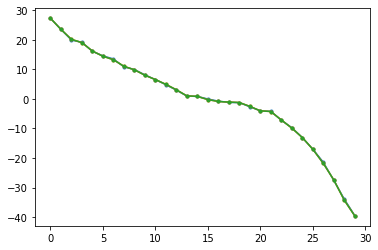

In [9]:
plt.plot(spectra(ds), '.-')
plt.plot(spectra(ds, geometry='B'), '.-')
plt.plot(sorted_spec, '.-', label = 'BLE')

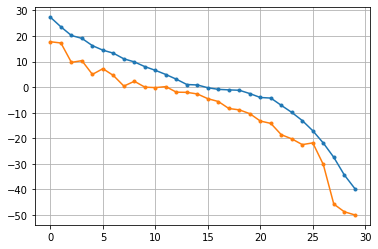

In [13]:
sorted_spec = np.flip(np.sort(spectra(ds, geometry='B').values))
plt.plot(sorted_spec, '.-', label = 'BLE')
plt.plot(julia_spec, '.-', label = 'Julia LE')
plt.grid()
plt.show()

In [11]:
julia_ds = xr.open_dataset('lyap55.jld2')

In [12]:
julia_spec = julia_ds['lambda'].values

In [ ]:
julia_spec

In [ ]:
remainder=1
    print('heloo')

In [ ]:
# Integrator
runner = l96.Integrator(K=1, J=2)
tangent_runner = l96.TangentIntegrator(K=1, J=2)
ginelli_runner = utilities.Forward(tangent_runner, tau)

In [ ]:
ginelli_runner.run(10)
ginelli_runner.R